In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random
import numpy as np
from PIL import Image
import pandas as pd
import os 
import matplotlib.pyplot as plt
import math
import random
import torch.nn.functional as F

In [2]:
words=open('names.txt').read().splitlines()
chars=sorted(list(set(''.join(words))))
s_to_i={s:i+1 for i,s in enumerate(chars) }
s_to_i['.']=0
i_to_s={i:s for s,i in s_to_i.items()}
vocab_size=len(i_to_s)
s_to_i

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [3]:
context_length=3
def build_dataset(words):
    x,y=[],[]
    for w in words:
        # print(w)
        context=[0]*context_length
        for ch in w+'.':
            idx=s_to_i[ch]
            x.append(context)
            y.append(idx)
            # print(''.join(i_to_s[i] for i in context),'--->',i_to_s[idx])
            context=context[1:]+[idx]
    x=torch.tensor(x)
    y=torch.tensor(y)
    print(x.shape,y.shape)
    return x,y


random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

x_train,y_train=build_dataset(words[:n1])
x_val,y_val=build_dataset(words[n1:n2])
x_test,y_test=build_dataset(words[n2:])



torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [4]:
for x,y in zip(x_train[:20],y_train[:20]):
    print(''.join(i_to_s[idx.item()]for idx in x),'-->',i_to_s[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [5]:
class Linear:
    def __init__(self,fan_in,fan_out,bias=True):
        self.weights=torch.randn((fan_in,fan_out))/(fan_in**0.5)
        self.bias=torch.zeros(fan_out) if bias else None 
        
    def __call__(self,x):
        self.out=x @ self.weights 
        if self.bias is not None:
            self.out+=self.bias
        return  self.out
        
    def parameters(self):
        return [self.weights]+ ([] if self.bias is None else [self.bias])

class BatchNorm1d_wavenet:
    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps=eps
        self.momentum=momentum
        self.training=True
        # paramameters for scale and shift
        self.gamma=torch.ones(dim)
        self.beta=torch.zeros(dim)
        # buffers
        self.running_mean=torch.zeros(dim)
        self.running_var=torch.ones(dim)

    def __call__(self,x):
        if self.training:
            if x.ndim==2:
                dim=0
            elif x.ndim==3:
                dim=(0,1)
            xmean=x.mean(dim,keepdim=True)
            xvar=x.var(dim,keepdim=True)
        else:
            xmean=self.running_mean
            xvar=self.running_var
        xnorm=(x-xmean)/torch.sqrt(xvar+self.eps)
        self.out=self.gamma*xnorm+self.beta
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean=(1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var=(1-self.momentum)*self.running_var+self.momentum*xvar
                
        return self.out

class BatchNorm1d:
    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps=eps
        self.momentum=momentum
        self.training=True
        # paramameters for scale and shift
        self.gamma=torch.ones(dim)
        self.beta=torch.zeros(dim)
        # buffers
        self.running_mean=torch.zeros(dim)
        self.running_var=torch.ones(dim)

    def __call__(self,x):
        if self.training:
            xmean=x.mean(0,keepdim=True)
            xvar=x.var(0,keepdim=True)
        else:
            xmean=self.running_mean
            xvar=self.running_var
        xnorm=(x-xmean)/torch.sqrt(xvar+self.eps)
        self.out=self.gamma*xnorm+self.beta
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean=(1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var=(1-self.momentum)*self.running_var+self.momentum*xvar
                
        return self.out
        
    def parameters(self):
        return [self.gamma,self.beta]

class LayerNorm1d:
    def __init__(self,dim,eps=1e-5):
        self.eps=eps
        # paramameters for scale and shift
        self.gamma=torch.ones(dim)
        self.beta=torch.zeros(dim)
        
    def __call__(self,x):

        xmean=x.mean(1,keepdim=True)
        xvar=x.var(1,keepdim=True)
        xnorm=(x-xmean)/torch.sqrt(xvar+self.eps)
        self.out=self.gamma*xnorm+self.beta
                
        return self.out
        
    def parameters(self):
        return [self.gamma,self.beta]
        

class Tanh:
    def __call__(self,x):
        self.out=torch.tanh(x)
        return self.out
    def parameters(self):
        return []


class Relu:
    def __call__(self,x):
        self.out=F.relu(x)
        return self.out
    def parameters(self):
        return []


class Sigmoid:
    def __call__(self,x):
        self.out=torch.sigmoid(x)
        return self.out
    def parameters(self):
        return []

        
class Embeddings:
    def __init__(self,num_embeds,emb_dim):
        self.emb_weights=torch.randn((num_embeds,emb_dim))

    def __call__(self,idx):
        self.out=self.emb_weights[idx]
        return self.out

    def parameters(self):
        return [self.emb_weights]

class FlattenConsecutive_wavenet:
    def __init__(self,n):
        self.n=n
        
    def __call__(self,x):
        B,T,C=x.shape
        x=x.view(B,T//self.n,C*self.n)
        if x.shape[1]==1:
            x=x.squeeze(1)
        self.out=x
        return self.out

    def parameters(self):
        return []

class Flatten:
    def __call__(self,x):
        self.out=x.view(x.shape[0],-1)
        return self.out

    def parameters(self):
        return []
    

class Sequential:
    def __init__(self,layers):
        self.layers=layers

    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        self.out=x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        


In [6]:
def plot_activations(model,activation):

    
    if activation=='Tanh':
        plt.figure(figsize=(20,4))
        legends=[]
        for i, layer in enumerate(model.layers[:-1]):
            if isinstance(layer,Tanh):
                t=layer.out
                print('layer %d (%10s): mean %+.2f, std %.2f, saturated:%.2f%%' % (i,layer.__class__.__name__, t.mean(),t.std(),(t.abs()>0.97).float().mean()*100))
                hy,hx=torch.histogram(t,density=True)
                plt.plot(hx[:-1].detach(),hy.detach())
                legends.append(f'layer {i} ({layer.__class__.__name__}')
        plt.legend(legends)
        plt.title('activation distribution');


    if activation=='Relu':
        plt.figure(figsize=(20,4))
        legends=[]
        for i, layer in enumerate(model.layers[:-1]):
            if isinstance(layer,Tanh):
                t=layer.out
                print('layer %d (%10s): mean %+.2f, std %.2f, saturated:%.2f%%' % (i,layer.__class__.__name__, t.mean(),t.std(),((t<=0).float().mean()*100)))
                hy,hx=torch.histogram(t,density=True)
                plt.plot(hx[:-1].detach(),hy.detach())
                legends.append(f'layer {i} ({layer.__class__.__name__}')
        plt.legend(legends)
        plt.title('activation distribution');

    if activation=='Sigmoid':
        plt.figure(figsize=(20,4))
        legends=[]
        for i, layer in enumerate(model.layers[:-1]):
            if isinstance(layer,Sigmoid):
                t=layer.out
                print('layer %d (%10s): mean %+.2f, std %.2f, saturated:%.2f%%' % (i,layer.__class__.__name__, t.mean(),t.std(),((t.abs()>0.97)|(t.abs()<0.03)).float().mean()*100))
                hy,hx=torch.histogram(t,density=True)
                plt.plot(hx[:-1].detach(),hy.detach())
                legends.append(f'layer {i} ({layer.__class__.__name__}')
        plt.legend(legends)
        plt.title('activation distribution');
# thus we get low saturation as we go deeper in the layers 



def plot_pre_activations(model):
    plt.figure(figsize=(20,4))
    legends=[]
    for i, layer in enumerate(model.layers[:-1]):
        if isinstance(layer,Linear):
            t=layer.out
            print('layer %d (%10s): mean %+.2f, std %.2f' % (i,layer.__class__.__name__, t.mean(),t.std()))
            hy,hx=torch.histogram(t,density=True)
            plt.plot(hx[:-1].detach(),hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends)
    plt.title('pre-activation distribution');
# thus all pre activations have a simillar distribution indicating good training

def plot_logits_distribution():
    l= model.layers[-1].out  
    hy, hx = torch.histogram(l, density=True)  # Compute histogram
    bin_centers = (hx[:-1] + hx[1:]) 
    # Plot the histogram
    plt.subplot(2,1,1)
    plt.plot(bin_centers.detach(), hy.detach())
    plt.xlabel('logit Values')
    plt.ylabel('Density')
    plt.title('logit Distribution of Last Layer')
    plt.show()
    print(bin_centers.detach().std())
    
    l=model.layers[-1].out.grad
    hy, hx = torch.histogram(l, density=True)  # Compute histogram
    bin_centers = (hx[:-1] + hx[1:]) 
    # Plot the histogram
    plt.plot(2,1,2)
    plt.plot(bin_centers.detach(),hy.detach());
    plt.xlabel(' gradients')
    plt.ylabel(' freaquency')
    plt.title('gradient Distribution of Last Layer')
    plt.show()


def neuron_activations(model,activation):
    if activation=='Relu':
        for i in range(11):
            l = model.layers[i].out
            plt.imshow(l.abs()<=0, cmap='gray',interpolation='nearest');
            print(f'saturation%:{((l.abs()>0).float().mean()*100)}')
            plt.title(f'neuron activation map of {i}th layer')
            plt.show()

    if activation=='Tanh':
        for i in range(11):
            l = model.layers[i].out
            if isinstance(model.layers[i],Tanh):
                plt.imshow(l.abs()>0.99, cmap='gray',interpolation='nearest')
                
                print(f'saturation%:{((l.abs()>0.97).float().mean()*100)}')
                plt.title(f'neuron activation map of {i}th layer')
                plt.show()

    if  activation=='Sigmoid':
     for i in range(11):
        l = model.layers[i].out
        if isinstance(model.layers[i],Tanh):
            plt.imshow((l.abs()>0.99) | (l.abs()<0.03), cmap='gray',interpolation='nearest')
            
            print(f'saturation%:{((l.abs()>0.99) | (l.abs()<0.03).float().mean()*100)}')
            plt.title(f'neuron activation map of {i}th layer')
            plt.show()
         

def plot_activation_gradients(model,activation):
    plt.figure(figsize=(20,4))
    legends=[]
    for i, layer in enumerate(model.layers[:-1]):
        if isinstance(layer,activation):
            t=layer.out.grad
            print('layer %d (%10s): mean %+.2f, std %.2f' % (i,layer.__class__.__name__, t.mean(),t.std()))
            hy,hx=torch.histogram(t,density=True)
            plt.plot(hx[:-1].detach(),hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends)
    plt.title('gradient distribution');


def plot_weights_grads():
    plt.figure(figsize=(20,7))
    legends=[]
    for i, layer in enumerate(model.layers):
            for p in layer.parameters():
                t=p.grad
                if p.ndim==2:
                    print('weights (%10s): mean %+f, std %e, grad:data ratio %e' % (tuple(p.shape), t.mean(),t.std(),t.std()/p.std()))
                    hy,hx=torch.histogram(t,density=True)
                    plt.subplot(2,1,1)
                    plt.plot(hx[:-1].detach(),hy.detach())
                    legends.append(f'layer{i} ({layer.__class__.__name__}) ')
    plt.legend(legends)
    plt.title('weight gradient distribution');


    
    
    

    

In [7]:
torch.manual_seed(42);

In [8]:
# hyperparameters 
batch_size=32
emb_space=10
context_length=3
# batch_dim=2
h_units=100

lossi=[]
steps=[]
lri=[]
lrex=[]
ud=[]

# model=Sequential([Embeddings(vocab_size,emb_space),
#     FlattenConsecutive(batch_dim),Linear(emb_space*2,h_units,bias=False),BatchNorm1d(h_units),Tanh(),
#     FlattenConsecutive(batch_dim),Linear(h_units*2,h_units,bias=False),BatchNorm1d(h_units),Tanh(),
#     FlattenConsecutive(batch_dim),Linear(h_units*2,h_units,bias=False),BatchNorm1d(h_units),Tanh(),
#     Linear(h_units,vocab_size)
# ])

model=Sequential([Embeddings(vocab_size,emb_space),
    Flatten(),Linear(emb_space*context_length,h_units,bias=False),LayerNorm1d(h_units),Tanh(),
    Linear(h_units,h_units,bias=False),LayerNorm1d(h_units),Tanh(),
    Linear(h_units,h_units,bias=False),LayerNorm1d(h_units),Tanh(),
    
    Linear(h_units,vocab_size),
])


with torch.no_grad():
    model.layers[-1].weights*=0.1
    # layers[-1].gamma*=0.1  # making last layer less confident 
    # for layer in layers[:-1]:
    #     if isinstance(layer,Linear):
    #         layer.weights*=5/3

parameters= model.parameters()
for p in parameters:
    p.requires_grad=True

print(sum(p.nelement() for p in parameters))


26597


In [9]:
from tqdm.auto import tqdm 

In [10]:

max_steps=200000
for i in tqdm(range(max_steps)):
    #minibatch construct
    ix=torch.randint(0,x_train.shape[0],(batch_size,)) 
    #foward pass
    x=x_train[ix]
    logits=model(x)
    loss=F.cross_entropy(logits,y_train[ix])
    #backward pass
    for layer in model.layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad=None
    loss.backward()
    
    lr=0.1 if i<150000 else 0.01
        
    for p in parameters:
            p.data+=-lr*p.grad

     # track stats
    if i%10000==0:
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
    steps.append(i)
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std()/ p.data.std()).log10().item() for p in parameters])
    # # break
    # if i>9998:
    #     break

  0%|          | 0/200000 [00:00<?, ?it/s]

      0/ 200000 : 3.2919
  10000/ 200000 : 2.1776
  20000/ 200000 : 1.9848
  30000/ 200000 : 2.0685
  40000/ 200000 : 1.6455
  50000/ 200000 : 1.8871
  60000/ 200000 : 1.8000
  70000/ 200000 : 2.3245
  80000/ 200000 : 2.1078
  90000/ 200000 : 2.4889
 100000/ 200000 : 1.7384
 110000/ 200000 : 1.9469
 120000/ 200000 : 1.9768
 130000/ 200000 : 2.0977
 140000/ 200000 : 2.1470
 150000/ 200000 : 2.1521
 160000/ 200000 : 2.0554
 170000/ 200000 : 2.2435
 180000/ 200000 : 2.1926
 190000/ 200000 : 1.6466


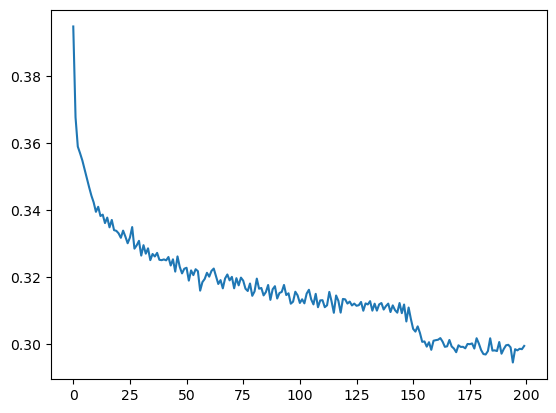

In [11]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1));

layer 4 (      Tanh): mean -0.01, std 0.81, saturated:32.03%
layer 7 (      Tanh): mean +0.01, std 0.84, saturated:38.44%
layer 10 (      Tanh): mean -0.01, std 0.61, saturated:12.75%


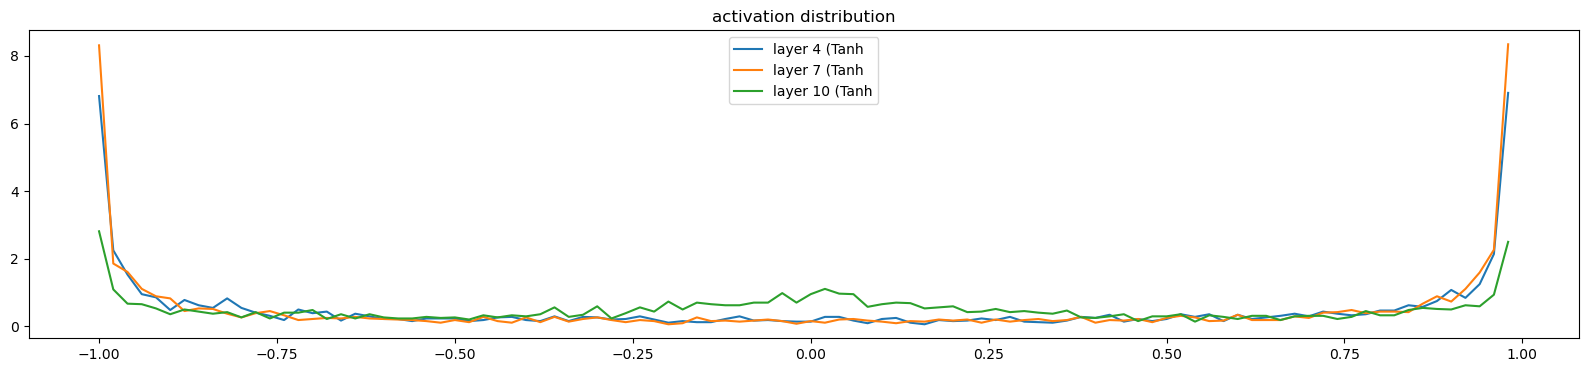

In [12]:
plot_activations(model,'Tanh')

layer 2 (    Linear): mean +0.07, std 2.58
layer 5 (    Linear): mean +0.01, std 2.99
layer 8 (    Linear): mean -0.04, std 3.52


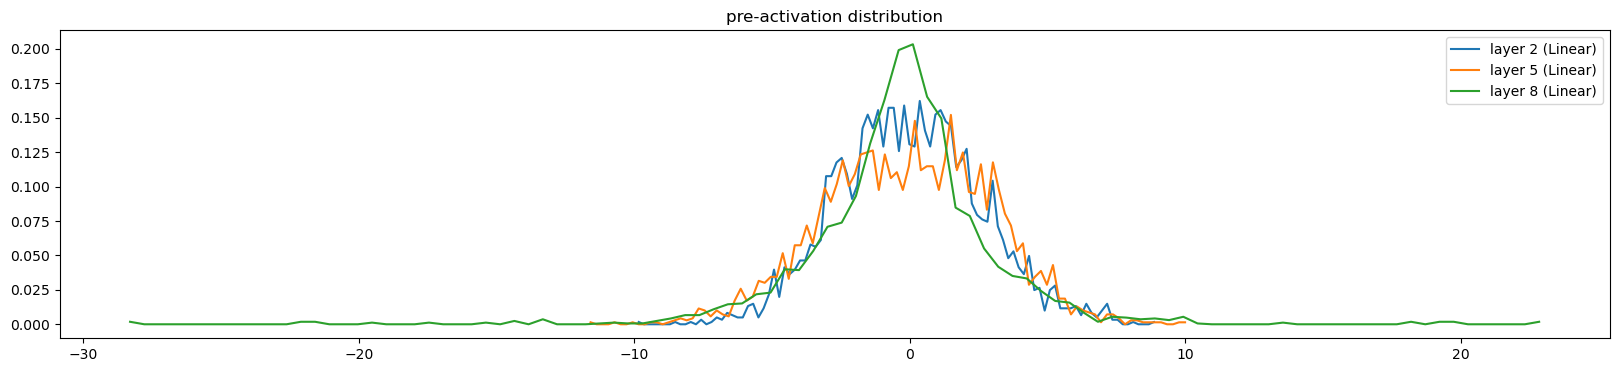

In [13]:
plot_pre_activations(model)

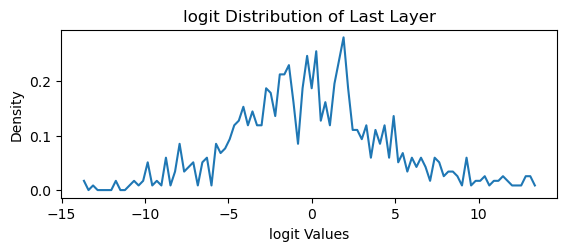

tensor(7.9204)


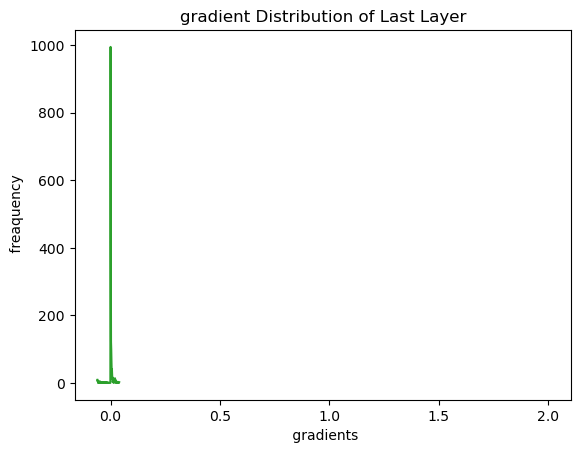

In [14]:
plot_logits_distribution()

saturation%:32.03125


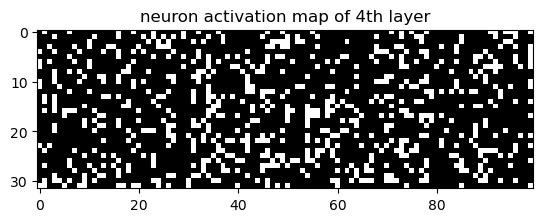

saturation%:38.4375


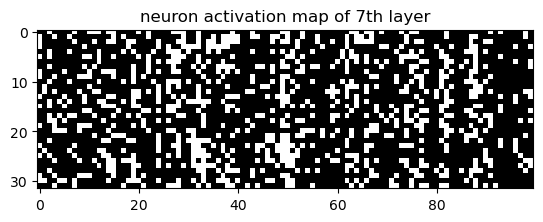

saturation%:12.75


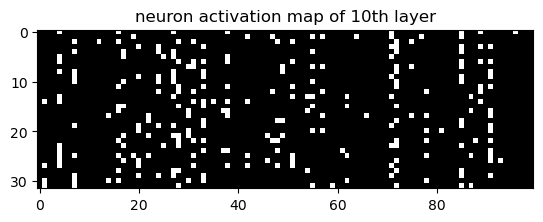

In [15]:
neuron_activations(model,'Tanh')

layer 4 (      Tanh): mean -0.00, std 0.00
layer 7 (      Tanh): mean +0.00, std 0.01
layer 10 (      Tanh): mean +0.00, std 0.01


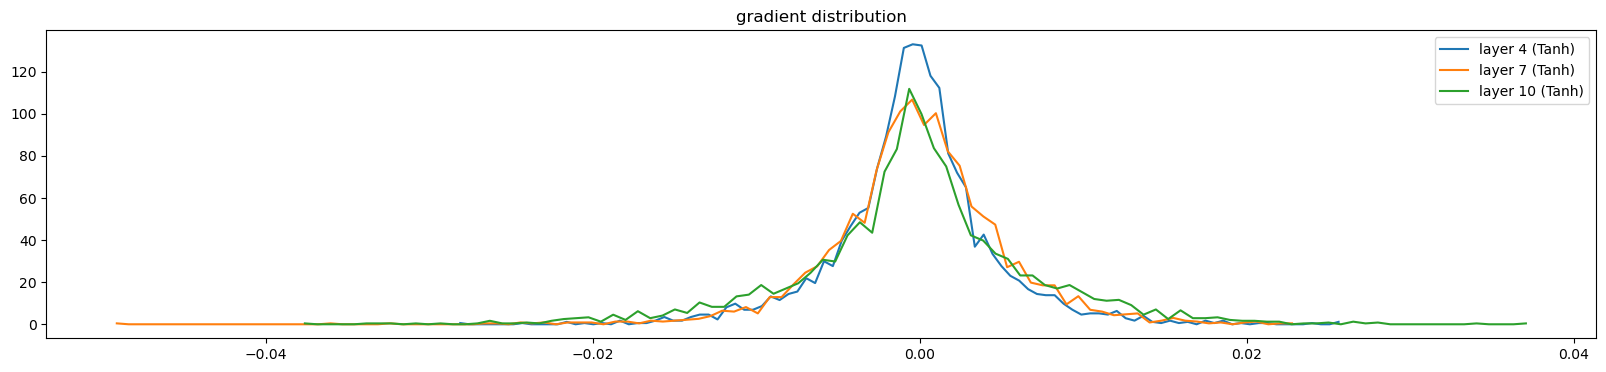

In [16]:
plot_activation_gradients(model,Tanh)

weights (  (27, 10)): mean -0.000871, std 1.947825e-02, grad:data ratio 1.672590e-02
weights ( (30, 100)): mean -0.000000, std 1.139568e-02, grad:data ratio 2.476418e-02
weights ((100, 100)): mean +0.000000, std 6.999546e-03, grad:data ratio 2.429927e-02
weights ((100, 100)): mean +0.000000, std 7.321639e-03, grad:data ratio 2.596671e-02
weights ( (100, 27)): mean -0.000000, std 1.887282e-02, grad:data ratio 6.697419e-02


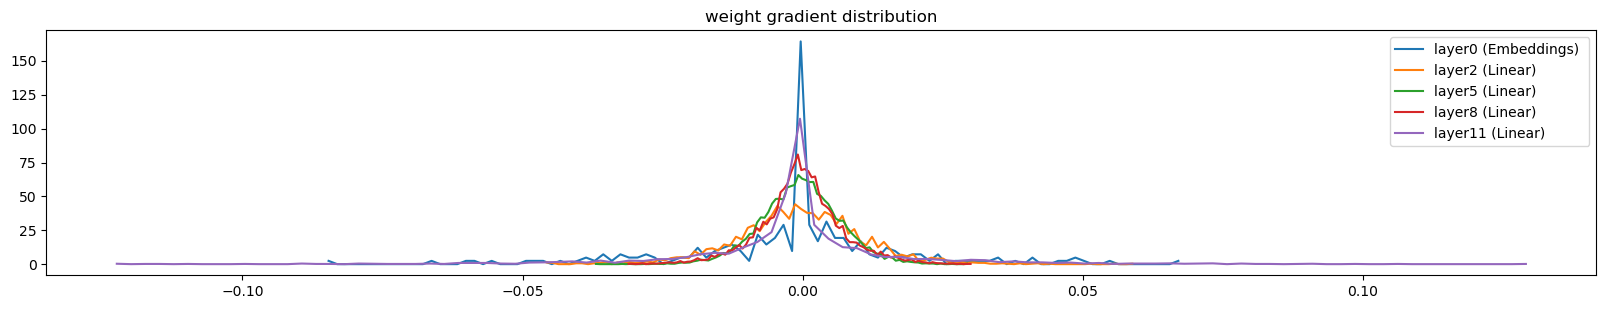

In [17]:
plot_weights_grads()

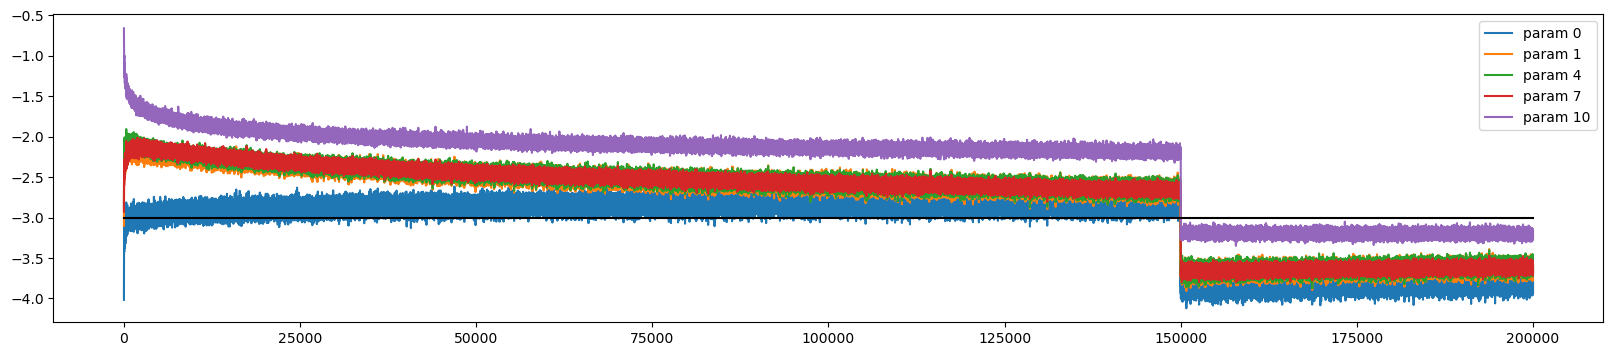

In [18]:
plt.figure(figsize=(20,4))
legends=[]
for i, p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0,len(ud)],[-3,-3],'k')
plt.legend(legends)

In [19]:
for layer in model.layers:
    layer.training=False


In [20]:
@torch.no_grad()
def split_loss(split):
    x,y={
        'train':(x_train,y_train),
        'val':(x_val,y_val),
        'test':(x_test,y_test)
        }[split]
    
    logits=model(x)
    loss=F.cross_entropy(logits,y)
    
    print(split,loss.item())

split_loss('train')
split_loss('val')

train 2.000293731689453
val 2.088819742202759


In [21]:
# # sampling from the moodel 
# g=torch.Generator().manual_seed(2147483647)
for i in range(20):
    out=[]
    context=[0]*context_length
    while True:
        # emb=C[torch.tensor([context])] #(1,conntext_length,d)
        x=torch.tensor([context])
        logits=model(x)
        probs=F.softmax(logits,dim=1)
        idx=torch.multinomial(probs,num_samples=1).item()
        context=context[1:]+[idx]
        out.append(idx)
        if idx==0:
            break
    print(''.join(i_to_s[i] for i in out))

zay.
khelston.
luisinclind.
dakylandrein.
dreaan.
musor.
soparyanny.
meireyaan.
gralyn.
beil.
omariah.
miyah.
amarinton.
ayah.
sannielyss.
aubree.
juliah.
deminaier.
chrey.
pypanie.


In [22]:
# ix=torch.randint(0,x_train.shape[0],(4,))
# logits=model(x_train[ix])
# # print(x_train[ix].shape)

# # model.layers[0].out.shape

# # model.layers[1].out.shape

# # model.layers[2].out.shape

# # model.layers[5].out.shape

# for layer in model.layers:
#     print(layer.__class__.__name__,layer.out.shape)

# # (1 2) (3 4) (5 6) (7 8)
# print(' ')
# for layer in model.layers:
#     if isinstance(layer,Linear):
#         print(layer.out.shape,layer.weights.shape)

In [23]:
class Conv_Layer:
    def __init__(self, filter_dim = 3, stride = 1, pad = 1, alpha=0.01):
        self.filter_dim = filter_dim
        self.stride = stride
        self.filter = np.random.randn(self.filter_dim, self.filter_dim)
        self.filter = self.filter/self.filter.sum()
        self.bias = np.random.rand()/10
        self.pad = pad
        self.alpha = alpha

    def convolving(self, X, fil, dimen_x, dimen_y):
        z = np.zeros((dimen_x, dimen_y))
        for i in range(dimen_x):
            for ii in range(dimen_y):
                temp = np.multiply(X[i : i+fil.shape[0], ii : ii+fil.shape[1]], fil)
                z[i,ii] = temp.sum()
        return z

In [25]:
print('with batchNorm : train 2.0253610610961914 val 2.0905704498291016 ')
print('with layerNorm : train 2.000293731689453 val 2.088819742202759')

with batchNorm : train 2.0253610610961914 val 2.0905704498291016 
with layerNorm : train 2.000293731689453 val 2.088819742202759
